In [69]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

#Structure type
from pandas import DataFrame
from typing import Any, Dict, List

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [3]:
lima = context.catalog.load('lima')

2021-06-26 07:50:41,217 - kedro.io.data_catalog - INFO - Loading data from `lima` (CSVDataSet)...


In [4]:
lima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116934 entries, 0 to 116933
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DATE    116934 non-null  object 
 1   HOUR    116111 non-null  object 
 2   TEMP    98744 non-null   float64
 3   PREC_H  72417 non-null   float64
 4   HUM     98773 non-null   float64
 5   W_DIR   98758 non-null   float64
 6   W_VEL   98760 non-null   float64
dtypes: float64(5), object(2)
memory usage: 6.2+ MB


In [5]:
lima.describe(include = 'all')

,DATE,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL
count,116934,116111,98744.000000,72417.000000,98773.000000,98758.000000,98760.000000
unique,5661,24,NaN,NaN,NaN,NaN,NaN
top,2011-01-04,05:00:00,NaN,NaN,NaN,NaN,NaN
freq,24,4838,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,19.831569,0.337479,81.763407,219.358432,1.700102
std,NaN,NaN,3.404527,1.391119,9.031431,45.324859,1.242962
min,NaN,NaN,-80.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,17.000000,0.000000,77.000000,210.000000,0.700000
50%,NaN,NaN,19.400000,0.000000,84.000000,221.000000,1.500000
75%,NaN,NaN,22.300000,0.000000,88.000000,234.000000,2.400000


In [65]:
def _combine_date_time(df, datecol, timecol):
    """Aux function to combine datetime"""
    return pd.to_datetime(df[datecol].dt.date.astype(str)+ ' '+ df[timecol].astype(str))
    

def clean_date_hour(df: DataFrame) -> DataFrame:
    """Preenche a coluna de hora com a parte de hora que está no date e deixa date só date,
    cria uma nova coluna com datetime
    Input:
        - df: DataFrame
    Output:
        - df:DataFrame        
    """
    #dropando uma linha errada
    df = df.drop(61564)
    
    temp_date = pd.DataFrame([date.split(' ') for date in df.DATE])
    temp_date.columns = ['DATE','HOUR']
    
    df['HOUR'] = df['HOUR'].fillna(temp_date['HOUR'])
    df['DATE'] = temp_date['DATE']
    df['DATE'] = pd.to_datetime(df['DATE'], infer_datetime_format = True)
    df = df[df['DATE'].notna()]
    df['MONTH'] = df['DATE'].dt.month
    df['MONTH'] = df['MONTH'].astype(int)
    
    df['YEAR'] = df['DATE'].dt.year
    df['YEAR'] = df['YEAR'].astype(int)
    df['HOUR_DT'] = pd.to_datetime(df['HOUR'], format = '%H:%M:%S')
    df['HOUR_DT'] = df['HOUR_DT'].dt.time
    
    df['DATETIME'] = _combine_date_time(df, 'DATE', 'HOUR_DT')
    df.set_index('DATETIME', inplace = True)
   
    return df

def clean_nulls(df: DataFrame) -> DataFrame:
    """ Preenche com pela media ou mediana agrupada por ano, mes e hora.
    
    Args :
        Input: 
        DataFrame
        Output:
        DataFrame
        
    """
    #temp por media
    df['TEMP'] = df.groupby(['YEAR', 'MONTH', 'HOUR'])\
                   .TEMP.transform(lambda x: x.fillna(x.mean()))
    df['TEMP'] = df.groupby(['YEAR', 'MONTH'])\
                   .TEMP.transform(lambda x: x.fillna(x.mean()))
    #chuva por median
    df['PREC_H'] = df.groupby(['YEAR', 'MONTH', 'HOUR'])\
                   .PREC_H.transform(lambda x: x.fillna(x.median()))
    df['PREC_H'] = df.groupby(['YEAR', 'MONTH'])\
                   .PREC_H.transform(lambda x: x.fillna(x.median()))
        
        
    #humidade por mediana
    df['HUM'] = df.groupby(['YEAR', 'MONTH', 'HOUR'])\
                   .HUM.transform(lambda x: x.fillna(x.median()))
    df['HUM'] = df.groupby(['YEAR', 'MONTH'])\
                   .HUM.transform(lambda x: x.fillna(x.median()))
        
    # direcao por media 
    df['W_DIR'] = df.groupby(['YEAR', 'MONTH', 'HOUR'])\
                   .W_DIR.transform(lambda x: x.fillna(x.mean()))
    df['W_DIR'] = df.groupby(['YEAR', 'MONTH'])\
                   .W_DIR.transform(lambda x: x.fillna(x.mean()))
    # velocidade do vento POR MEDIAN
    df['W_VEL'] = df.groupby(['YEAR', 'MONTH', 'HOUR'])\
                   .W_VEL.transform(lambda x: x.fillna(x.median()))
    df['W_VEL'] = df.groupby(['YEAR', 'MONTH'])\
                   .W_VEL.transform(lambda x: x.fillna(x.median()))
    df = df.fillna(method= 'bfill')
    return df

def setindex_peru(df: DataFrame) -> DataFrame:
    """Muda a coluna data para datetime e depois coloca como index """
    df['date'] = pd.to_datetime(peru['date'], infer_datetime_format=True)
    df.set_index('date',inplace = True)
    return df

def select_date(df: DataFrame, params: Dict[str, Any]) -> DataFrame:
    """ Seleciona data catalogada como parametro """
    df = df.loc[date:]
    return df


    
    

In [7]:
lima = clean_date_hour(lima)
lima


,DATE,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL,MONTH,YEAR,HOUR_DT,DATETIME
0,2006-01-01,00:00:00,NaN,NaN,NaN,NaN,NaN,1,2006,00:00:00,2006-01-01 00:00:00
1,2006-01-02,00:00:00,NaN,NaN,NaN,NaN,NaN,1,2006,00:00:00,2006-01-02 00:00:00
2,2006-01-03,00:00:00,NaN,NaN,NaN,NaN,NaN,1,2006,00:00:00,2006-01-03 00:00:00
3,2006-01-04,00:00:00,NaN,NaN,NaN,NaN,NaN,1,2006,00:00:00,2006-01-04 00:00:00
4,2006-01-05,00:00:00,NaN,NaN,NaN,NaN,NaN,1,2006,00:00:00,2006-01-05 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
116928,2021-06-30,18:00:00,NaN,NaN,NaN,NaN,NaN,6,2021,18:00:00,2021-06-30 18:00:00
116929,2021-06-30,19:00:00,NaN,NaN,NaN,NaN,NaN,6,2021,19:00:00,2021-06-30 19:00:00
116930,2021-06-30,20:00:00,NaN,NaN,NaN,NaN,NaN,6,2021,20:00:00,2021-06-30 20:00:00
116931,2021-06-30,21:00:00,NaN,NaN,NaN,NaN,NaN,6,2021,21:00:00,2021-06-30 21:00:00


<Figure size 864x576 with 0 Axes>

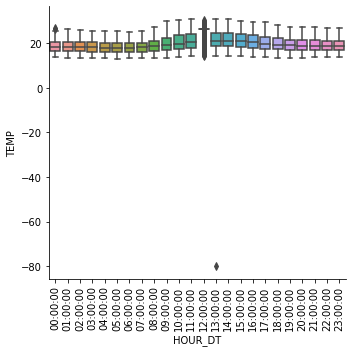

In [17]:
plt.figure(figsize = (12,8))
sns.catplot(x= 'MONTH', y = 'TEMP', data = lima, kind = 'box')
plt.xticks(rotation = '90')
plt.tight_layout()


In [9]:
lima = clean_nulls(lima)
lima

,DATE,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL,MONTH,YEAR,HOUR_DT,DATETIME
0,2006-01-01,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00,2006-01-01 00:00:00
1,2006-01-02,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00,2006-01-02 00:00:00
2,2006-01-03,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00,2006-01-03 00:00:00
3,2006-01-04,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00,2006-01-04 00:00:00
4,2006-01-05,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00,2006-01-05 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
116928,2021-06-30,18:00:00,17.638889,0.0,84.0,214.111111,2.20,6,2021,18:00:00,2021-06-30 18:00:00
116929,2021-06-30,19:00:00,17.538889,0.0,84.0,215.222222,1.80,6,2021,19:00:00,2021-06-30 19:00:00
116930,2021-06-30,20:00:00,17.472222,0.0,85.5,214.555556,1.85,6,2021,20:00:00,2021-06-30 20:00:00
116931,2021-06-30,21:00:00,17.388889,0.0,86.0,213.388889,2.05,6,2021,21:00:00,2021-06-30 21:00:00


In [10]:
lima.describe()

,TEMP,PREC_H,HUM,W_DIR,W_VEL,MONTH,YEAR
count,116932.000000,116932.000000,116932.000000,116932.000000,116932.000000,116932.000000,116932.000000
mean,19.753283,0.269504,81.726645,219.629609,1.611504,6.455974,2014.094405
std,3.314139,1.271141,8.819725,42.860914,1.215765,3.523888,4.195858
min,-80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,17.033333,0.000000,77.000000,210.000000,0.700000,3.000000,2011.000000
50%,19.300000,0.000000,84.000000,222.000000,1.400000,6.000000,2014.000000
75%,22.100000,0.000000,88.000000,234.409091,2.300000,10.000000,2018.000000
max,31.000000,10.200000,100.000000,360.000000,12.800000,12.000000,2021.000000


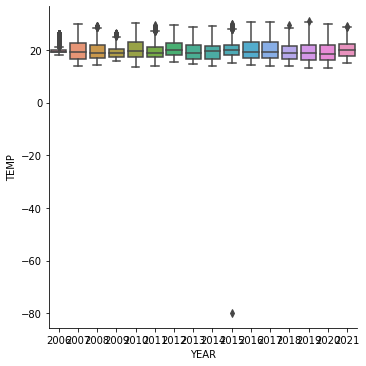

In [37]:

sns.catplot(x= 'YEAR', y = 'TEMP', data = lima, kind = 'box')

In [56]:
peru = context.catalog.load('peru')

2021-06-26 08:14:44,494 - kedro.io.data_catalog - INFO - Loading data from `peru` (CSVDataSet)...


<AxesSubplot:>

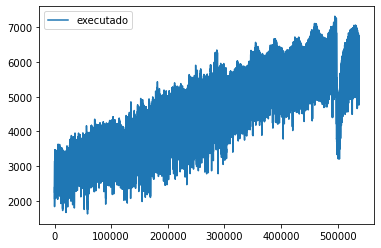

In [21]:
peru.plot()

In [28]:
# O que aconteceu no valor minimo e quando?
peru

,date,executado
0,2006-01-01 00:00:00,2069.01876
1,2006-01-01 00:15:00,2733.44840
2,2006-01-01 00:30:00,2681.27092
3,2006-01-01 00:45:00,2633.54249
4,2006-01-01 01:00:00,2611.28745
...,...,...
537691,2021-05-02 22:45:00,5842.71088
537692,2021-05-02 23:00:00,5789.96126
537693,2021-05-02 23:15:00,5708.78075
537694,2021-05-02 23:30:00,5660.78965


In [31]:
peru['date'] = pd.to_datetime(peru['date'], infer_datetime_format=True)
peru.set_index('date',inplace = True)
peru

,executado
date,
2006-01-01 00:00:00,2069.01876
2006-01-01 00:15:00,2733.44840
2006-01-01 00:30:00,2681.27092
2006-01-01 00:45:00,2633.54249
2006-01-01 01:00:00,2611.28745
...,...
2021-05-02 22:45:00,5842.71088
2021-05-02 23:00:00,5789.96126
2021-05-02 23:15:00,5708.78075


<AxesSubplot:xlabel='date'>

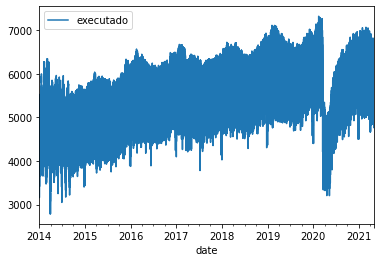

In [36]:
# Filtrar a partir de 2014
peru = peru.loc['2014':]

In [52]:
peru.loc['2020-03-16':,'pos_covid'] = 1
peru.fillna(0, inplace = True)

In [66]:
peru = context.catalog.load('peru')
peru = setindex_peru(peru)
peru = select_date(peru)
peru = create_covidfeature(peru)

peru

2021-06-26 08:35:57,236 - kedro.io.data_catalog - INFO - Loading data from `peru` (CSVDataSet)...


,executado,pos_covid
date,,
2014-01-01 00:00:00,4219.36716,0
2014-01-01 00:15:00,4295.46962,0
2014-01-01 00:30:00,4290.86630,0
2014-01-01 00:45:00,4211.82225,0
2014-01-01 01:00:00,4184.15299,0
...,...,...
2021-05-02 22:45:00,5842.71088,1
2021-05-02 23:00:00,5789.96126,1
2021-05-02 23:15:00,5708.78075,1


In [67]:
lima = context.catalog.load('lima')
lima = clean_date_hour(lima)
lima = clean_nulls(lima)
lima = select_date(lima)
lima = create_covidfeature(lima)
lima


2021-06-26 08:36:03,575 - kedro.io.data_catalog - INFO - Loading data from `lima` (CSVDataSet)...


,DATE,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL,MONTH,YEAR,HOUR_DT,pos_covid
DATETIME,,,,,,,,,,,
2014-01-01 00:00:00,2014-01-01,00:00:00,21.000000,0.0,78.0,235.000000,1.30,1,2014,00:00:00,0
2014-01-01 01:00:00,2014-01-01,01:00:00,20.700000,0.0,81.0,271.000000,1.40,1,2014,01:00:00,0
2014-01-01 02:00:00,2014-01-01,02:00:00,20.400000,0.0,83.0,234.000000,1.30,1,2014,02:00:00,0
2014-01-01 03:00:00,2014-01-01,03:00:00,20.200000,0.0,84.0,229.000000,0.70,1,2014,03:00:00,0
2014-01-01 04:00:00,2014-01-01,04:00:00,20.000000,0.0,86.0,213.000000,0.70,1,2014,04:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,2021-06-30,18:00:00,17.638889,0.0,84.0,214.111111,2.20,6,2021,18:00:00,1
2021-06-30 19:00:00,2021-06-30,19:00:00,17.538889,0.0,84.0,215.222222,1.80,6,2021,19:00:00,1
2021-06-30 20:00:00,2021-06-30,20:00:00,17.472222,0.0,85.5,214.555556,1.85,6,2021,20:00:00,1


In [60]:
lima

,DATE,HOUR,TEMP,PREC_H,HUM,W_DIR,W_VEL,MONTH,YEAR,HOUR_DT
DATETIME,,,,,,,,,,
2006-01-01 00:00:00,2006-01-01,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00
2006-01-02 00:00:00,2006-01-02,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00
2006-01-03 00:00:00,2006-01-03,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00
2006-01-04 00:00:00,2006-01-04,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00
2006-01-05 00:00:00,2006-01-05,00:00:00,19.100000,0.0,86.0,241.000000,1.20,1,2006,00:00:00
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,2021-06-30,18:00:00,17.638889,0.0,84.0,214.111111,2.20,6,2021,18:00:00
2021-06-30 19:00:00,2021-06-30,19:00:00,17.538889,0.0,84.0,215.222222,1.80,6,2021,19:00:00
2021-06-30 20:00:00,2021-06-30,20:00:00,17.472222,0.0,85.5,214.555556,1.85,6,2021,20:00:00
